# Customer Churn

This project helps an e-commerce business understand the factors driving customer churn and to take proactive measures (e.g., customer retention strategies) to reduce churn and improve customer loyalty.

#### Data

The dataset consists of customer demographics, engagement metrics, and subscription history. Key features in the dataset include:

- Tenure: How long the customer has been with the company (numeric)
- WarehouseToHome: Distance between the warehouse and the customer's home (numeric)
- NumberOfDeviceRegistered: Number of devices registered by the customer (numeric)
- PreferedOrderCat: Preferred order category (categorical)
- SatisfactionScore: Satisfaction score based on customer service (numeric)
- MaritalStatus: Marital status of the customer (categorical)
- NumberOfAddress: Number of addresses linked to the customer (numeric)
- Complain: Whether the customer has filed a complaint (binary)
- DaySinceLastOrder: Days since the customer last placed an order (numeric)
- CashbackAmount: Average cashback earned by the customer (numeric)
- Churn: Target variable (binary, 1 for churn, 0 for non-churn)

Class Distribution (Post-Balancing)

- Non-Churn (0): 1934 samples
- Churn (1): 1354 samples

This project provides valuable insights for e-commerce businesses considering reducing customer churn and improving loyalty. By identifying key factors that influence churn, such as customer complaints, tenure, and satisfaction, this analysis can help with enhancing customer retention efforts. For example, this analysis shows customers who complain more and have shorter tenures are more likely to churn, suggesting that focusing on improving satisfaction and addressing complaints proactively could help in retaining at-risk customers.

### 1. Import Libraries

In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

# Sklearn Libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# imbalanced-learn Libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# XGBoost
from xgboost import XGBClassifier

### 2. Load and Inspect the Dataset

In [2]:
# Load dataset
csv_file_path = 'data_ecommerce_customer_churn.csv'
df = pd.read_csv(csv_file_path, encoding='latin1', on_bad_lines='skip')

# Inspect the first few rows
df.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


In [3]:
# Summary Statistics
print("\nSummary Statistics:\n", df.describe())

# Check Data Types and Missing Values
print("\nDataset Information:\n", df.info())

# Check for missing values
print("\nMissing Values Before Cleaning:\n", df.isnull().sum())


Summary Statistics:
             Tenure  WarehouseToHome  NumberOfDeviceRegistered  \
count  3747.000000      3772.000000               3941.000000   
mean     10.081398        15.650583                  3.679269   
std       8.498864         8.452301                  1.013938   
min       0.000000         5.000000                  1.000000   
25%       2.000000         9.000000                  3.000000   
50%       9.000000        14.000000                  4.000000   
75%      16.000000        21.000000                  4.000000   
max      61.000000       127.000000                  6.000000   

       SatisfactionScore  NumberOfAddress     Complain  DaySinceLastOrder  \
count        3941.000000      3941.000000  3941.000000        3728.000000   
mean            3.088302         4.237757     0.282416           4.531652   
std             1.381832         2.626699     0.450232           3.667648   
min             1.000000         1.000000     0.000000           0.000000   
25%    

### 3. Data Cleaning and Preprocessing

In [4]:
# Handling Missing Values (Imputation)
numerical_columns = ['Tenure', 'WarehouseToHome', 'DaySinceLastOrder']
for column in numerical_columns:
    median_value = df[column].median()
    df[column].fillna(median_value, inplace=True)

# Verify no missing values remain
print("\nMissing Values After Cleaning:\n", df.isnull().sum())

# Remove Outliers using IQR Method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal for numerical columns
numerical_columns += ['CashbackAmount', 'NumberOfDeviceRegistered', 'NumberOfAddress']
for column in numerical_columns:
    df = remove_outliers(df, column)


Missing Values After Cleaning:
 Tenure                      0
WarehouseToHome             0
NumberOfDeviceRegistered    0
PreferedOrderCat            0
SatisfactionScore           0
MaritalStatus               0
NumberOfAddress             0
Complain                    0
DaySinceLastOrder           0
CashbackAmount              0
Churn                       0
dtype: int64


C:\Users\milto\AppData\Local\Temp\ipykernel_16572\482113883.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(median_value, inplace=True)


### 4. Feature Engineering

In [5]:
# Encode Categorical Features
categorical_columns = ['PreferedOrderCat', 'MaritalStatus']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Feature Scaling (Standardize)
scaler = StandardScaler()
features_to_scale = ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'NumberOfAddress', 
                     'DaySinceLastOrder', 'CashbackAmount', 'SatisfactionScore']
df_encoded[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])

# Derived Features (Create New Features)
df_encoded['AvgCashbackPerInteraction'] = df_encoded['CashbackAmount'] / (df_encoded['NumberOfDeviceRegistered'] + 1)
df_encoded['ComplaintsPerTenure'] = df_encoded['Complain'] / (df_encoded['Tenure'] + 1)
df_encoded['EngagementIntensity'] = df_encoded['NumberOfDeviceRegistered'] + df_encoded['SatisfactionScore'] + df_encoded['Complain']

In [6]:
# Feature Correlation and Removal of Highly Correlated Features
correlation_matrix = df_encoded.corr()
high_corr = [(col1, col2) for (col1, col2), val in correlation_matrix.unstack().items() if col1 != col2 and abs(val) > 0.85]
for col1, col2 in high_corr:
    if col2 in df_encoded.columns:
        df_encoded.drop(columns=[col2], inplace=True)

### 5. Data Balancing: Handling Class Imbalance

In [7]:
# Prepare Features and Target
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

# Class Imbalance: SMOTE and Undersampling
over = SMOTE(sampling_strategy=0.5, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
pipeline = Pipeline(steps=[('o', over), ('u', under)])
X_balanced, y_balanced = pipeline.fit_resample(X, y)

# Class Distribution After Balancing
print("\nClass distribution after balancing:\n", y_balanced.value_counts())

C:\Users\milto\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Class distribution after balancing:
 Churn
0    1934
1    1354
Name: count, dtype: int64


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


### 6. Data Analysis and Visualizations

In [9]:
# Churn Rate Calculation
churn_rate = df['Churn'].mean() * 100
print(f"Churn Rate: {churn_rate:.2f}%")

Churn Rate: 18.28%


#### What is the churn rate? Churn Distribution (Pie Chart/Bar Plot)

Churn Rate: 18.28%


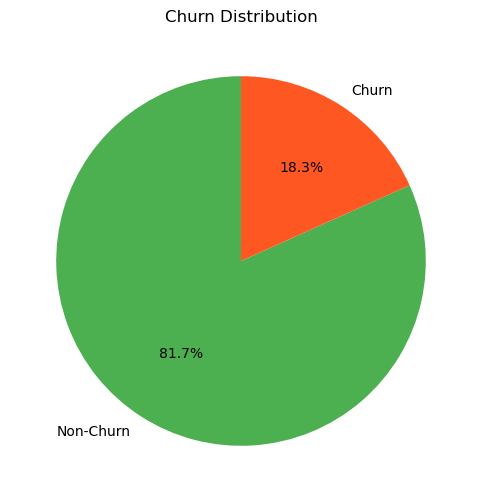

In [10]:
# Churn Rate Calculation
churn_rate = df['Churn'].mean() * 100
print(f"Churn Rate: {churn_rate:.2f}%")

# Churn Distribution (Pie Chart)
plt.figure(figsize=(6,6))
churn_dist = df['Churn'].value_counts()
churn_dist.plot(kind='pie', autopct='%1.1f%%', startangle=90, labels=["Non-Churn", "Churn"], colors=['#4CAF50', '#FF5722'])
plt.title("Churn Distribution")
plt.ylabel("")  # Remove the y-axis label
plt.show()

#### How does customer tenure impact churn? Churn by Customer Tenure (Box Plot/Violin Plot)

C:\Users\milto\AppData\Local\Temp\ipykernel_16572\2687928360.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='Tenure', data=df, palette='Set2')


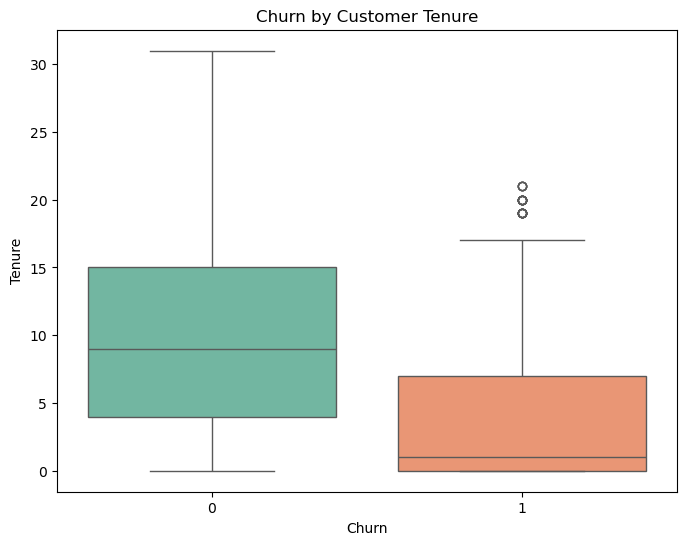

In [11]:
# Churn by Customer Tenure (Box Plot)
plt.figure(figsize=(8,6))
sns.boxplot(x='Churn', y='Tenure', data=df, palette='Set2')
plt.title('Churn by Customer Tenure')
plt.show()

#### How do customer satisfaction and complaints relate to churn? Churn vs. Satisfaction Score (Box Plot/Violin Plot)

C:\Users\milto\AppData\Local\Temp\ipykernel_16572\2951610417.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='SatisfactionScore', data=df, palette='Set1')


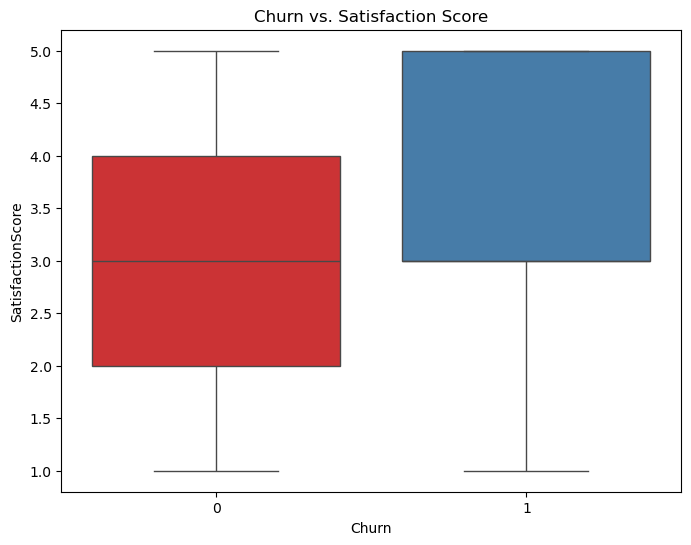

In [12]:
# Churn vs. Satisfaction Score (Box Plot)
plt.figure(figsize=(8,6))
sns.boxplot(x='Churn', y='SatisfactionScore', data=df, palette='Set1')
plt.title('Churn vs. Satisfaction Score')
plt.show()

#### How does the frequency of orders (e.g., "DaySinceLastOrder") affect churn?

C:\Users\milto\AppData\Local\Temp\ipykernel_16572\1026389509.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='DaySinceLastOrder', data=df, palette='Set2')


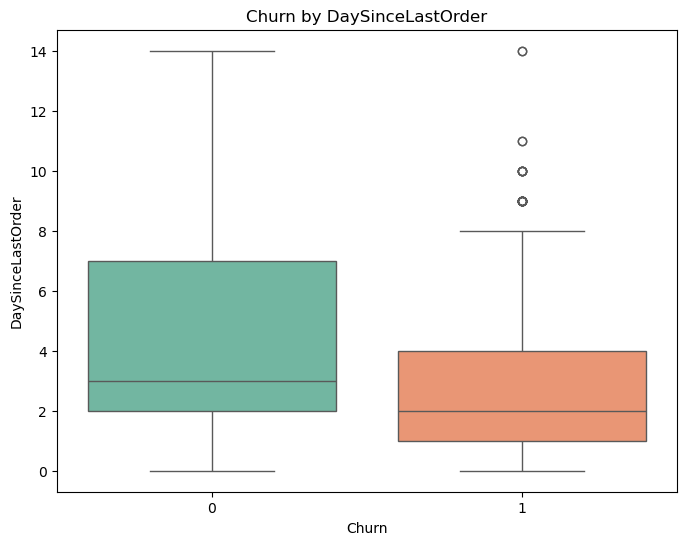

In [13]:
# Churn by DaySinceLastOrder (Box Plot)
plt.figure(figsize=(8,6))
sns.boxplot(x='Churn', y='DaySinceLastOrder', data=df, palette='Set2')
plt.title('Churn by DaySinceLastOrder')
plt.show()

#### Churn vs. Number of Complaints (Bar Plot/Violin Plot)

C:\Users\milto\AppData\Local\Temp\ipykernel_16572\1388563195.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Churn', y='Complain', data=df, palette='Set2')


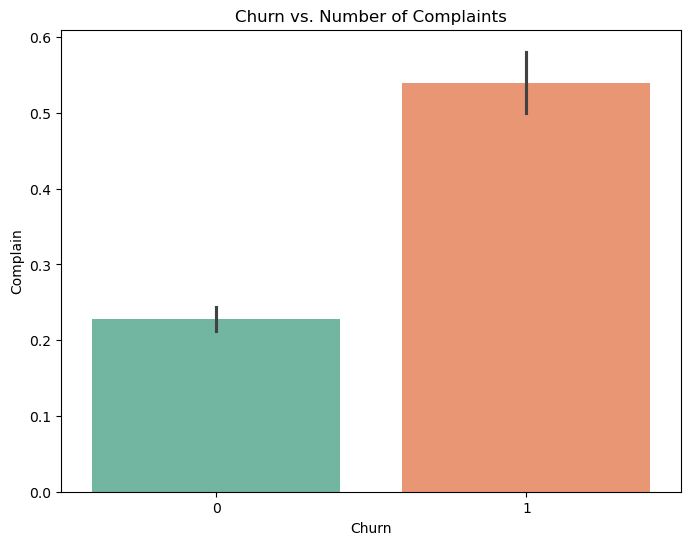

In [14]:
# Churn vs. Number of Complaints (Bar Plot)
plt.figure(figsize=(8,6))
sns.barplot(x='Churn', y='Complain', data=df, palette='Set2')
plt.title('Churn vs. Number of Complaints')
plt.show()

#### Heatmap of Correlations (Correlation Matrix)

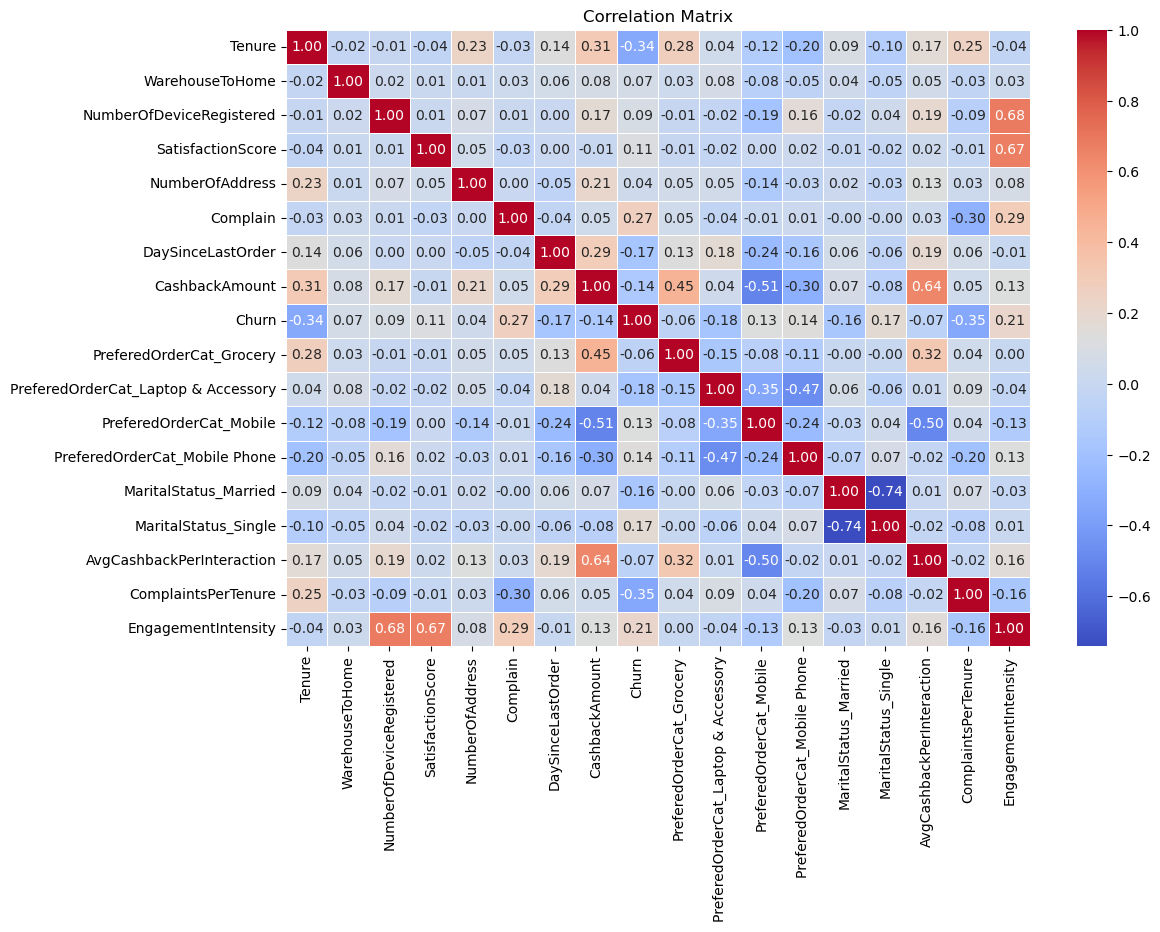

In [15]:
# Correlation Matrix (Heatmap)
corr_matrix = df_encoded.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Key Findings

- **Customer Engagement**: Higher device registrations, satisfaction, and tenure correlate with stronger engagement. Customers who are more engaged tend to also have a better satisfaction score.
- **Churn**: Customers who complain more and have shorter tenures are more likely to churn. Churn is also inversely correlated with tenure, so longer-tenured customers are generally less likely to leave.
- **Complaints**: The number of complaints seems to influence churn. Additionally, there is a notable correlation between complaints and tenure, with more complaints over time possibly leading to higher churn.

#### Segmentation Analysis: Segment the customers based on demographic or behavior data (e.g., marital status, number of devices) and analyze churn within each segment.

C:\Users\milto\AppData\Local\Temp\ipykernel_16572\2243843417.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MaritalStatus', y='Churn', data=df, palette='Set3')


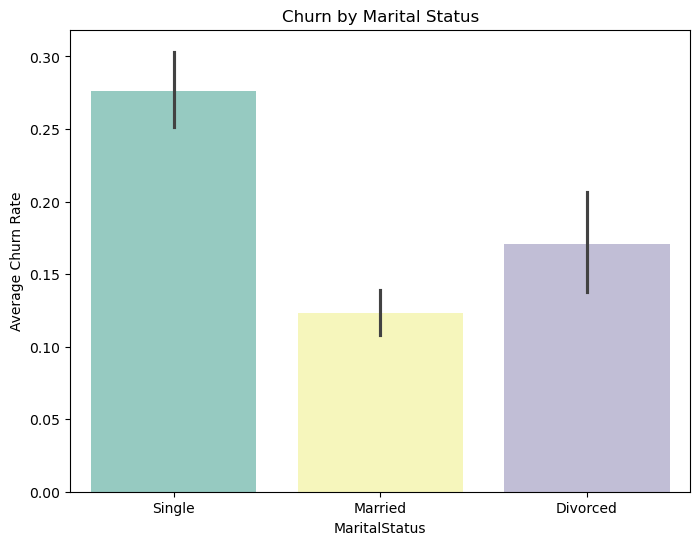

C:\Users\milto\AppData\Local\Temp\ipykernel_16572\2243843417.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='NumberOfDeviceRegistered', y='Churn', data=df, palette='Set3')


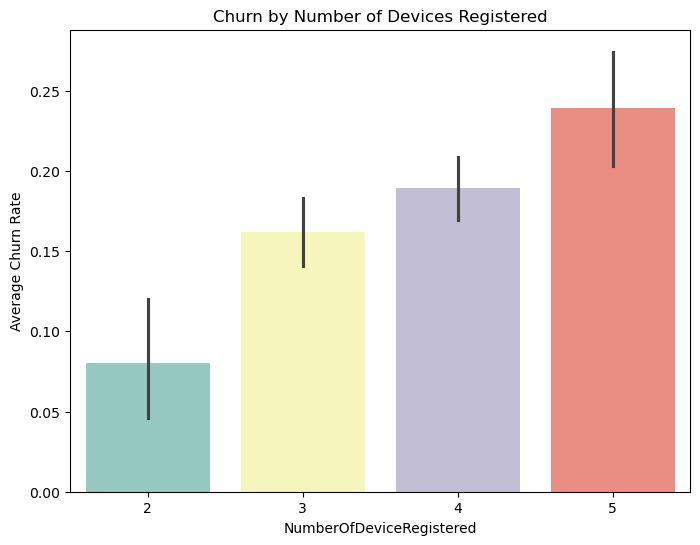

In [16]:
# Segmentation Analysis by Marital Status
plt.figure(figsize=(8,6))
sns.barplot(x='MaritalStatus', y='Churn', data=df, palette='Set3')
plt.title('Churn by Marital Status')
plt.ylabel('Average Churn Rate')
plt.show()

# Segmentation Analysis by Number of Devices
plt.figure(figsize=(8,6))
sns.barplot(x='NumberOfDeviceRegistered', y='Churn', data=df, palette='Set3')
plt.title('Churn by Number of Devices Registered')
plt.ylabel('Average Churn Rate')
plt.show()

#### Customer Journey Analysis: Track the events leading to churn (e.g., satisfaction drops, complaints, service issues).

C:\Users\milto\AppData\Local\Temp\ipykernel_16572\1954974148.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Churn', y='SatisfactionChange', data=df, palette='Set1')


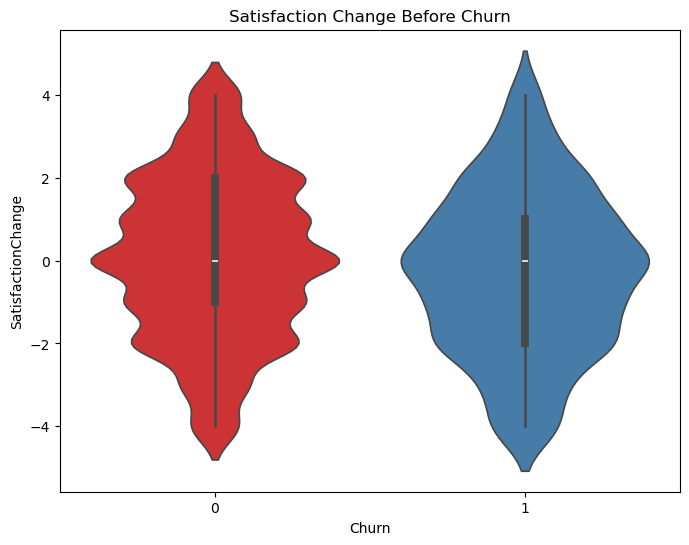

In [17]:
# Investigate satisfaction drops and complaints before churn
df['SatisfactionChange'] = df['SatisfactionScore'].diff().shift(-1)  # Satisfaction change
plt.figure(figsize=(8,6))
sns.violinplot(x='Churn', y='SatisfactionChange', data=df, palette='Set1')
plt.title('Satisfaction Change Before Churn')
plt.show()

#### Cost of Churn: Quantify the financial impact of churn and its effect on business.

### 7. Feature Importance

In [18]:
# Feature Importance using RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_balanced, y_balanced)
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)
print("\nFeature Importances:\n", feature_importance_df)


Feature Importances:
                                 Feature  Importance
0                                Tenure    0.230901
15                  ComplaintsPerTenure    0.120809
7                        CashbackAmount    0.099263
14            AvgCashbackPerInteraction    0.084521
16                  EngagementIntensity    0.073175
6                     DaySinceLastOrder    0.069549
1                       WarehouseToHome    0.062828
4                       NumberOfAddress    0.060370
3                     SatisfactionScore    0.049439
13                 MaritalStatus_Single    0.037846
5                              Complain    0.035824
2              NumberOfDeviceRegistered    0.019539
9   PreferedOrderCat_Laptop & Accessory    0.017141
11        PreferedOrderCat_Mobile Phone    0.014024
12                MaritalStatus_Married    0.013149
10              PreferedOrderCat_Mobile    0.009170
8              PreferedOrderCat_Grocery    0.002451


### Key Findings

- Tenure is the most important feature in the model, followed by complaints per tenure and cashback amount.
- Customer satisfaction, engagement intensity, and recency of interaction are also significant factors.
- Marital status and device registration have relatively lower importance.
- Product preferences (such as grocery and mobile) are the least impactful in this model.

### 8. Model Building and Evaluation

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Train XGBoost Classifier
xgb_clf = XGBClassifier(objective='binary:logistic', 
                        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 
                        random_state=42)
xgb_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_clf.predict(X_test)
print("\nXGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Confusion Matrix:
 [[379  27]
 [ 12 240]]

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       406
           1       0.90      0.95      0.92       252

    accuracy                           0.94       658
   macro avg       0.93      0.94      0.94       658
weighted avg       0.94      0.94      0.94       658



### Interpretation

- The model has very high performance, especially for class 0, with an F1-score of 0.95.
- For class 1, while the precision (0.90) is slightly lower than for class 0, the recall (0.95) is still very high, meaning the model is very good at identifying positive cases (class 1).
- The overall accuracy (0.94) shows that the model is very reliable, correctly predicting most of the instances.
- The high recall for both classes suggests the model is good at not missing any important cases, particularly class 1, which might be more critical in some contexts (e.g., in fraud detection or disease prediction).

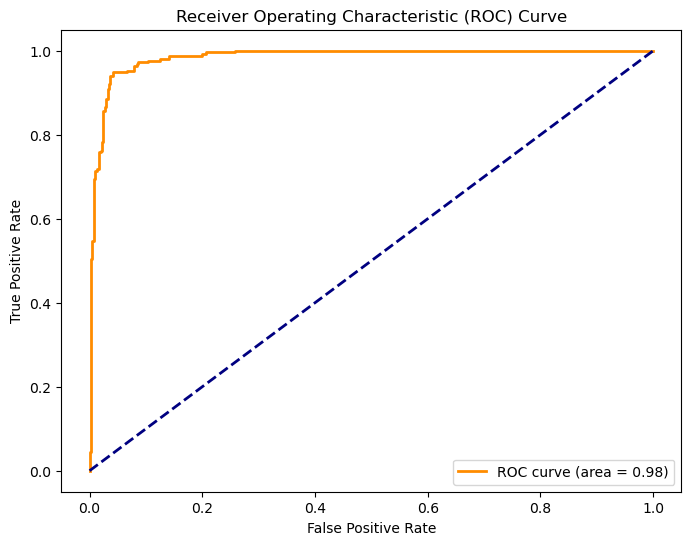

In [23]:
# Plot ROC Curve for XGBoost
fpr, tpr, _ = roc_curve(y_test, xgb_clf.predict_proba(X_test)[:, 1])
roc_auc = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### 9. Model Interpretability

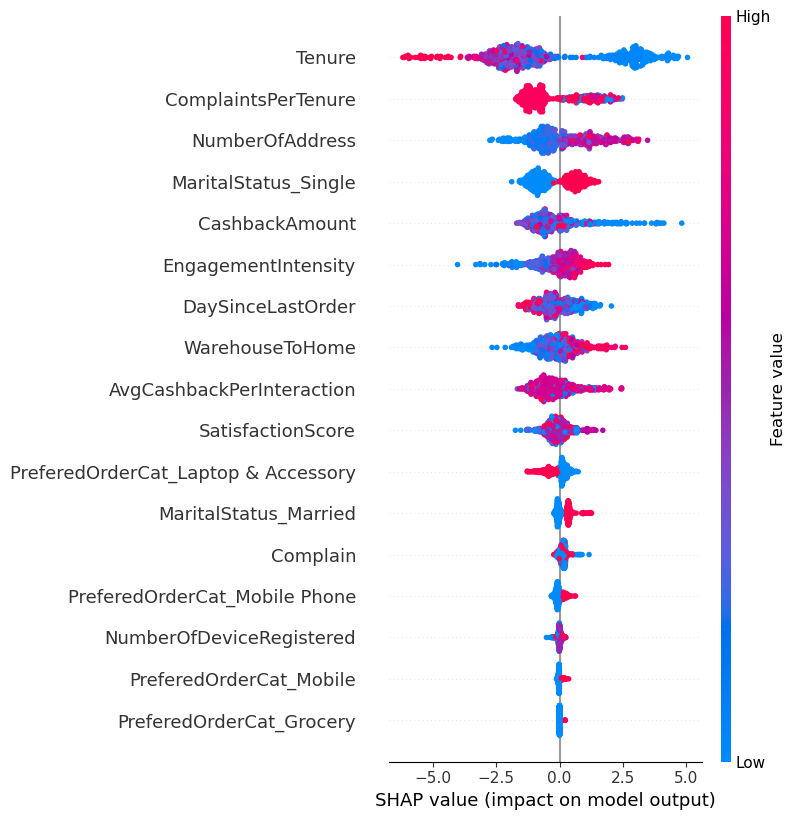

In [29]:
# SHAP for interpretability (same as before)
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test)  # Use X_test here
shap.summary_plot(shap_values, X_test)  # Use X_test here

<Figure size 800x600 with 0 Axes>

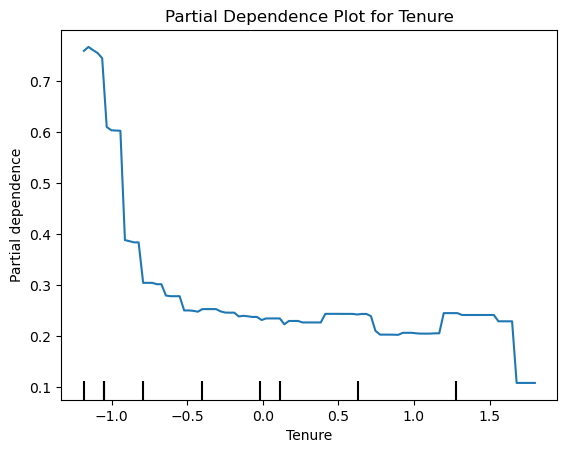

In [31]:
# PDP for 'Tenure'
plt.figure(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(
    xgb_clf, X_train, features=['Tenure'], target='Churn', response_method='predict_proba'
)
plt.title('Partial Dependence Plot for Tenure')
plt.show()

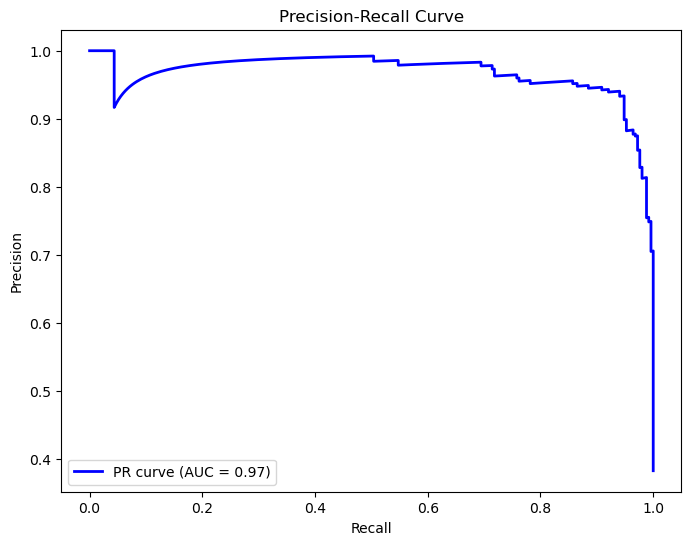

In [33]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, xgb_clf.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='b', lw=2, label=f'PR curve (AUC = {auc(recall, precision):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

## Conclusion

The model's feature importance analysis reveals that customer tenure, complaints per tenure, and cashback amount are the most significant predictors of churn. Additionally, engagement metrics such as customer satisfaction, engagement intensity, and the recency of interaction play a crucial role in understanding customer behavior. On the other hand, marital status and device registration have lower impact, while product preferences like grocery and mobile are not as influential in predicting churn.

The performance of the predictive model is outstanding, with a high F1-score of 0.95 for class 0 (non-churn), and a very strong recall for class 1 (churn), which indicates that the model is highly effective in identifying both non-churn and churn customers. The overall accuracy of 0.94 underscores the model's reliability in making predictions. This high recall for churn (class 1) is particularly valuable for businesses that need to prevent potential churn and take timely action, especially in contexts where customer retention is critical for revenue growth and long-term sustainability.

Overall, the results suggest that with the right interventions — such as focusing on customer complaints, increasing engagement, and rewarding loyal customers — this business can reduce churn rates and foster a loyal customer base.